In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import geemap
import ee
Map=geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [3]:
# 大庆市
# roi = ee.FeatureCollection('users/311605001111/ChinaCity').filter(ee.Filter.eq('市','大庆市'))
# 天津市
# roi = ee.FeatureCollection('users/311605001111/ChinaCity').filter(ee.Filter.eq('市','天津市'))
# 武汉市
roi = ee.FeatureCollection('users/311605001111/region/ChinaCity').filter(ee.Filter.eq('市','武汉市'))
# 珠三角
# roi = ee.Geometry.Rectangle([112.846779, 22.565455,113.682786, 23.114128])
# 青藏高原
# roi = ee.Geometry.Rectangle([86.974365, 30.431624,91.650147, 33.694569])
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,9)

In [4]:
# 移除无效像元
elevation = ee.Image('USGS/SRTMGL1_003').select('elevation').clip(roi)
def maskSR(image):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = image.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    azimuth = image.get('SOLAR_AZIMUTH_ANGLE')
    zenith = image.get('SOLAR_ZENITH_ANGLE')
    return image.updateMask(mask).updateMask(ee.Terrain.hillShadow(elevation,azimuth,zenith,200,True))

# 图像可视化参数
visParams = {'bands': ['B5', 'B6', 'B4'],'min': 0,'max': 3000,'gamma': 1.4}

## 指数的计算
def water_index(img):
    image = img.clip(roi)
    ndvi=image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    ndwi=image.normalizedDifference(['B3', 'B5']).rename("NDWI")
    mndwi=image.normalizedDifference(['B3', 'B6']).rename("mNDWI")
    ndvi_mndwi = ndvi.subtract(mndwi).rename('ndvi_mndwi')
    cwi=image.select('B3').divide(image.select('B6')).rename("CWI")
    awei = image.expression('B2 + 2.5*B3 - 1.5*(B5+B6) - 0.25*B7',
        {
          'B2': image.select('B2'),
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
          'B7': image.select('B7'),
        }).rename('AWEI')
    ewi = image.expression('(B3 - B5 - B6)/(B3 + B5 + B6)',
        {
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
        }).rename('EWI')
    evi = image.expression('2.5*(B5 - B4)/(B5 + 6*B4 - 7.5*B2 + 1)',
        {
          'B2': image.select('B2'),
          'B4': image.select('B4'),
          'B5': image.select('B5'),    
        }).rename('EVI')
    return image.addBands(ndvi).addBands(ndwi).addBands(mndwi).addBands(cwi).addBands(awei).addBands(ewi).addBands(evi).addBands(ndvi_mndwi)


In [5]:
l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
       .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi) \
       .filterDate('2018-01-01', '2018-12-31')\
       .map(maskSR)\
       .map(water_index)
Map.addLayer(l8.mosaic().clip(roi), visParams,'image mosaic')

In [28]:
def sample(image_id):
    man_point = ee.FeatureCollection('users/311605001111/manual_samples/WUHAN_2018').filter(ee.Filter.eq('Image_id',image_id))
    water_image = ee.Image.constant(1).toFloat().rename('label')
    land_image = ee.Image.constant(0).toFloat().rename('label')
    water = water_image.clipToCollection(man_point.filter(ee.Filter.eq('label',1)))
    land = land_image.clipToCollection(man_point.filter(ee.Filter.eq('label',0)))
    image_waterclass = ee.ImageCollection([water,land]).sum()
    validation_points = image_waterclass.sample(**{
        'region': roi,
        'scale': 30,
        'numPixels': 30000,
        'seed': 0,
        'geometries': True,
        'tileScale': 2,
    })
    image = l8.filter(ee.Filter.eq('system:index',image_id)).first()
    sample_points = image.select(['AWEI']).sampleRegions(**{
        'collection': validation_points,
        'properties': ['label'],
        'scale': 30,
        'geometries': True,
        'tileScale': 2,
    })
    return ee.FeatureCollection(sample_points)

In [29]:
# 加载样本集
samples = ee.FeatureCollection('users/311605001111/manual_samples/WUHAN_2018')
print(samples.size().getInfo())

# # 在样本集中，各类样本的个数
# clt_water = samples.filter(ee.Filter.eq('label',1))
# print(clt_water.size().getInfo())
# clt_nowater = samples.filter(ee.Filter.eq('label',0))
# print(clt_nowater.size().getInfo())

908


In [30]:
a = samples.distinct('Image_id').aggregate_array('Image_id')
b = ee.FeatureCollection(a.map(sample)).flatten()
print(b.size().getInfo())
print(b.first().getInfo())

3426
{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [114.67564868561135, 30.581283003170444]}, 'id': '0_33_0', 'properties': {'AWEI': 2372.75, 'label': 1}}


368


(array([ 4.,  8.,  9.,  7.,  3.,  6., 11., 17., 19., 12., 19., 31., 33.,
        31., 44., 28., 18., 14.,  9.,  3., 12.,  2.,  4.,  5.,  3.,  0.,
        10.,  1.,  1.,  4.]),
 array([ 589.25 ,  706.425,  823.6  ,  940.775, 1057.95 , 1175.125,
        1292.3  , 1409.475, 1526.65 , 1643.825, 1761.   , 1878.175,
        1995.35 , 2112.525, 2229.7  , 2346.875, 2464.05 , 2581.225,
        2698.4  , 2815.575, 2932.75 , 3049.925, 3167.1  , 3284.275,
        3401.45 , 3518.625, 3635.8  , 3752.975, 3870.15 , 3987.325,
        4104.5  ]),
 <BarContainer object of 30 artists>)

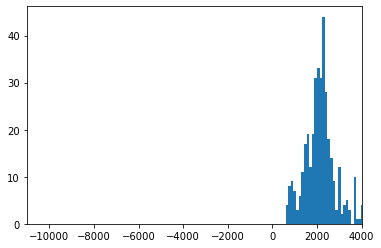

In [17]:
clt_water = b.filter(ee.Filter.eq('label',1))
print(clt_water.size().getInfo())

import numpy as np
import matplotlib.pyplot as plt
a = clt_water.aggregate_array('AWEI').getInfo()
plt.xlim(-11000,4000)
plt.hist(a,bins=30)

clt_nowater = b.filter(ee.Filter.eq('label',0))
print(clt_nowater.size().getInfo())
a = clt_nowater.aggregate_array('AWEI').getInfo()
plt.xlim(-11000,4000)
plt.hist(a,bins=30)

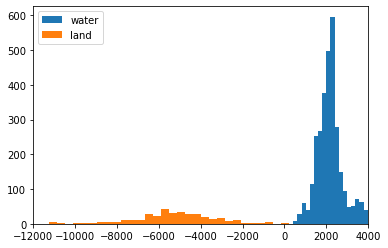

In [32]:
import numpy as np
import matplotlib.pyplot as plt
clt_water = b.filter(ee.Filter.eq('label',1)).aggregate_array('AWEI').getInfo()
# print(clt_nowater.size().getInfo())
clt_nowater = b.filter(ee.Filter.eq('label',0)).aggregate_array('AWEI').getInfo()
# print(clt_nowater.size().getInfo())

plt.xlim(-12000,4000)
plt.hist(clt_water,bins=30,label='water')
plt.hist(clt_nowater,bins=30,label='land')
plt.legend()